# 1 Problem Definition: Short Term Load Forecasting

Now the prblem includes Temperature as well, as an exogenous variable

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2024-09-13 13:58:49 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Libraries

In [2]:
#Local Installations
!pip install statsmodels

time: 2.03 s (started: 2024-09-13 13:58:49 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

time: 2.03 s (started: 2024-09-13 13:58:51 +02:00)


In [4]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

time: 141 ms (started: 2024-09-13 13:58:53 +02:00)


In [5]:
# ML Algorithms to be used
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

time: 62 ms (started: 2024-09-13 13:58:53 +02:00)


# 3. Pre-processing


In [6]:
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
def read_Data():
    data_path = os.path.join(RAW_DATA_PATH, "energy.csv") #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
    data = pd.read_csv(data_path)
    return data

time: 0 ns (started: 2024-09-13 13:58:53 +02:00)


In [7]:
data = read_Data()

time: 47 ms (started: 2024-09-13 13:58:53 +02:00)


In [8]:
data = data.dropna()
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
#Merging Columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data = data.sort_index()

time: 203 ms (started: 2024-09-13 13:58:53 +02:00)


# SVM I - Multi-step Forecasting with Exogenous variables

Multi-step forecasting involves predicting multiple future data points in the time series based on the previous data points. The model's objective is to predict a sequence of future values, given the historical data.

## Organizing the Feature Matrix

In [9]:
#Checking Data:
data.sample(3)

,load,T
2014-02-19 01:00:00,2991.0,20.67
2010-04-08 18:00:00,3344.0,54.00
2008-04-22 11:00:00,3480.0,60.67


time: 16 ms (started: 2024-09-13 13:58:53 +02:00)


In [10]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Let's use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 4
#Calling Rolling:
window = load_data.rolling(window=width)
#Let's save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std','T', 'load']
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78885 entries, 2006-01-01 03:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78885 non-null  float64
 1   std     78885 non-null  float64
 2   T       78885 non-null  float64
 3   load    78885 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 32 ms (started: 2024-09-13 13:58:53 +02:00)


In [11]:
new_dataframe.head(5)

,median,std,T,load
2006-01-01 03:00:00,2919.0,117.882710,21.33,2758.0
2006-01-01 04:00:00,2805.5,133.827003,19.00,2705.0
2006-01-01 05:00:00,2733.5,68.854315,19.33,2709.0
2006-01-01 06:00:00,2731.0,28.123241,18.67,2753.0
2006-01-01 07:00:00,2731.0,66.962676,18.00,2849.0


time: 0 ns (started: 2024-09-13 13:58:53 +02:00)


## Building the X Matrix and Labels

Here we will add the temporal data with sliding intervals in time. Lets first look with an illustration:

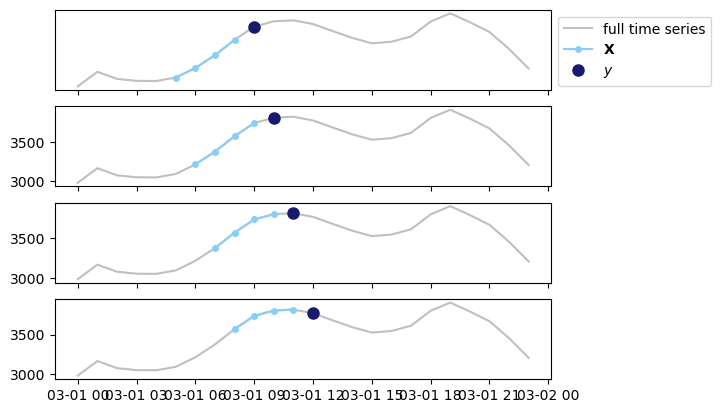

time: 812 ms (started: 2024-09-13 13:58:53 +02:00)


In [12]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2014-03-01 00:00:00')[0][0]
middle = np.where(new_dataframe.index == '2014-03-01 12:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-03-02 00:00:00')[0][0]
#sliding window width:
window = 4
#Plotting a sliding interval sample:
fig, ax = plt.subplots(nrows=4,sharex=True);
for i in range(4):
    full = new_dataframe.iloc[start:end]['load']
    train = new_dataframe.iloc[middle - i - window:middle - i ]['load']
    predict = new_dataframe.iloc[middle - i:middle - i + 1]['load']

    ax[3-i].plot((full + 2*i),c='grey', alpha=0.5);
    ax[3-i].plot((train + 2*i),c=colors['lightskyblue'], markersize=4,marker='o')
    ax[3-i].plot((predict + 2*i),c=colors['midnightblue'], markersize=8,marker='o', linestyle='')

ax[0].get_yaxis().set_ticks([]);
ax[0].legend(['full time series','$\mathbf{X}$','$y$'],bbox_to_anchor=(1, 1));


Lets follow the same logic and create our feature matrix A in this way.

In [13]:
# Step 1: Identify the start and end points for analysis
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-11-04 00:00:00')[0][0]

# Step 2: Define the sliding window width
window = 4

# Step 3: Initialize lists for features, labels, and column names
dataX, dataY, column_names_list = [], [], []

# Step 4: Extract features and labels using a sliding window
for i in range(start, end - window):
    # This loop iterates from the start index to (end - window). 
    # For each position i, it extracts a slice of the DataFrame 
    # corresponding to the current window and flattens it to a single array. 
    # This array becomes a row in the feature matrix dataX. 
    # The next value of the load (immediately after the window) 
    # is used as the label, stored in dataY.

    # Extract features from the current window and flatten them
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

# Step 5: Generate descriptive column names for features
for j in range (1,window+1):
    # For each time step j within the window, generate names for the median, 
    # standard deviation, temperature, and load columns. These names are 
    # stored in column_names, making the data more understandable.
      column_names_list.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

# Step 6: Flatten the list of column names
# Since column_names is a list of lists, use itertools.chain(*column_names) to flatten it into a single list.
column_names = itertools.chain(*column_names_list)

# Step 7: Convert features and labels into a DataFrame and Series
# The index of this DataFrame is set to match the DateTime 
# index of the slices from new_dataframe, offset by the window 
# width since these features predict the load value at the end of each window.
# Similarly, convert the labels list (dataY) into a pandas Series with the same index.

# dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
# dataX.columns = column_names
# dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
# dataY.name = ['true_load']

dataX = pd.DataFrame(dataX, columns=column_names, index=new_dataframe.index[start + window:end])
dataY = pd.Series(dataY, name='true_load', index=new_dataframe.index[start + window:end])

time: 1.23 s (started: 2024-09-13 13:58:54 +02:00)


In [14]:
#Original DF:
new_dataframe.loc['2012-09-01 00:00:00':'2012-09-04 00:00:00'].head(6)

,median,std,T,load
2012-09-01 00:00:00,3543.0,524.914199,59.33,2719.0
2012-09-01 01:00:00,3104.5,465.842964,69.67,2817.0
2012-09-01 02:00:00,2768.0,335.357521,67.33,2664.0
2012-09-01 03:00:00,2691.5,99.408249,69.33,2580.0
2012-09-01 04:00:00,2622.0,123.494939,67.67,2537.0
2012-09-01 05:00:00,2558.5,62.931179,65.00,2525.0


time: 15 ms (started: 2024-09-13 13:58:55 +02:00)


In [15]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,T_t_3,load_t_3,median_t_4,std_t_4,T_t_4,load_t_4
2012-09-01 04:00:00,3543.0,524.914199,59.33,2719.0,3104.5,465.842964,69.67,2817.0,2768.0,335.357521,67.33,2664.0,2691.5,99.408249,69.33,2580.0
2012-09-01 05:00:00,3104.5,465.842964,69.67,2817.0,2768.0,335.357521,67.33,2664.0,2691.5,99.408249,69.33,2580.0,2622.0,123.494939,67.67,2537.0


time: 0 ns (started: 2024-09-13 13:58:55 +02:00)


In [16]:
dataY.head(2)

2012-09-01 04:00:00    2537.0
2012-09-01 05:00:00    2525.0
Name: true_load, dtype: float64

time: 0 ns (started: 2024-09-13 13:58:55 +02:00)


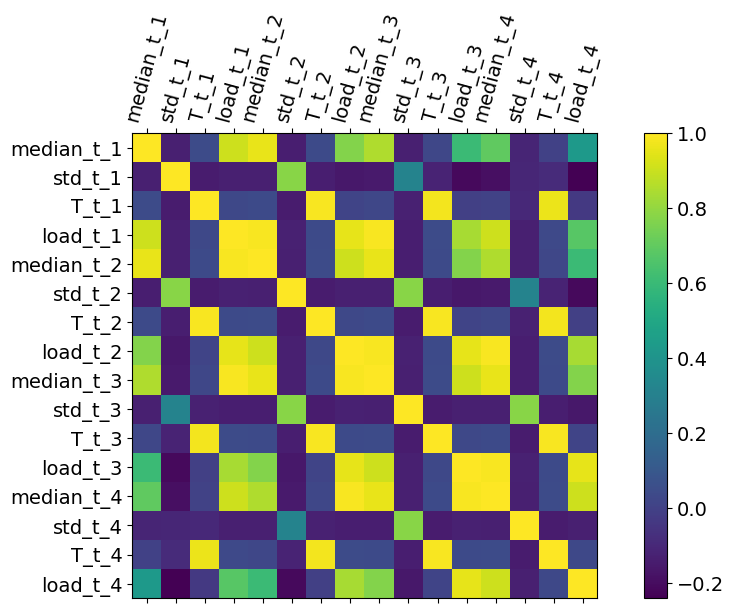

time: 250 ms (started: 2024-09-13 13:58:55 +02:00)


In [17]:
#Correlation Matrix
correlationMatrix = pd.DataFrame(dataX).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [18]:
#Rescaling the data
# For SVM Regression (SVR): It's not strictly required 
# to standardize or normalize dataY. The primary concern is 
# ensuring that the features (dataX) are on a similar 
# scale to facilitate the SVM's optimization process.

featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,T_t_3,load_t_3,median_t_4,std_t_4,T_t_4,load_t_4
count,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04
mean,2.565890e-16,-8.428651e-17,-3.818999e-16,-2.953757e-16,1.939336e-16,1.976631e-16,-2.267531e-16,9.845858e-17,-2.267531e-16,1.212085e-16,-1.670812e-16,-1.969172e-16,-1.581304e-16,-2.700152e-16,8.354061e-17,3.938343e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.356536e+00,-1.250854e+00,-3.150932e+00,-2.363943e+00,-2.356523e+00,-1.250961e+00,-3.150906e+00,-2.364070e+00,-2.356548e+00,-1.251018e+00,-3.150913e+00,-2.364173e+00,-2.356666e+00,-1.251030e+00,-3.150905e+00,-2.364310e+00
25%,-7.726966e-01,-8.791492e-01,-7.639865e-01,-7.721103e-01,-7.727081e-01,-8.791741e-01,-7.639432e-01,-7.722154e-01,-7.727602e-01,-8.791741e-01,-7.638814e-01,-7.722968e-01,-7.721740e-01,-8.791720e-01,-7.638207e-01,-7.723794e-01
50%,1.141806e-01,-3.143736e-01,9.416024e-02,1.191733e-01,1.141554e-01,-3.142749e-01,9.420957e-02,1.190803e-01,1.140882e-01,-3.141876e-01,9.429610e-02,1.190114e-01,1.140057e-01,-3.141646e-01,9.437566e-02,1.189593e-01
75%,6.730222e-01,7.707527e-01,7.982938e-01,6.788994e-01,6.729884e-01,7.708772e-01,7.983482e-01,6.788141e-01,6.729117e-01,7.710807e-01,7.984550e-01,6.787530e-01,6.728372e-01,7.711371e-01,7.985500e-01,6.787200e-01
max,3.458144e+00,4.153972e+00,2.446595e+00,3.420488e+00,3.458067e+00,4.155047e+00,2.446661e+00,3.420440e+00,3.457943e+00,4.155826e+00,2.446815e+00,3.420417e+00,3.457908e+00,4.156014e+00,2.446946e+00,3.420478e+00


time: 47 ms (started: 2024-09-13 13:58:56 +02:00)


In [19]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2012-09-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Let's use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (18980, 16) (18980,)
Test data shape:  (72, 16) (72,)
time: 0 ns (started: 2024-09-13 13:58:56 +02:00)


## Model Training and Predictions

As we have seen in the lecture, there are 3 important hyperparameters to decide: C, epsilon and kernel. We also need to feed the tol value as we are solving a convex optimization problem.

In [20]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
# Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
# against simplicity of the decision surface. 
# A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
# The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

# gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)
 

time: 0 ns (started: 2024-09-13 13:58:56 +02:00)


In [21]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(X_train, y_train)

SVR(kernel='linear', tol=1e-05)

time: 11 s (started: 2024-09-13 13:58:56 +02:00)


In [22]:
#Model Predictions:
#------------------
scoreTraining = model.score(X_train, y_train)
print('-----------------------------------')
print('SVM Regression Training R^2 Score: ', scoreTraining)
print('-----------------------------------')
scoreValidation = model.score(X_test, y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

-----------------------------------
SVM Regression Training R^2 Score:  0.9643835749377488
-----------------------------------
-----------------------------------
SVM Regression Validation R^2 Score:  0.9650015833976958
-----------------------------------
time: 5.38 s (started: 2024-09-13 13:59:07 +02:00)


Training MSE: 11217.427077741182
Test MSE: 7153.681207650938


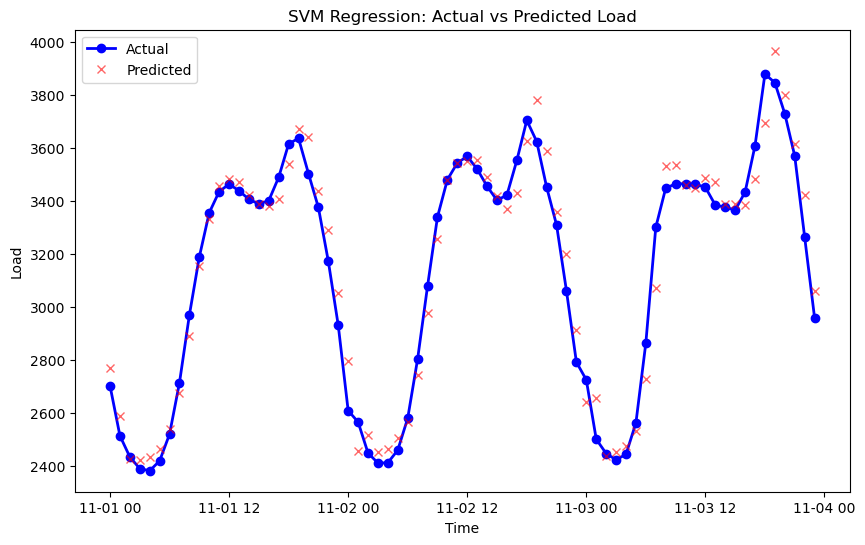

time: 5.51 s (started: 2024-09-13 13:59:12 +02:00)


In [23]:
# Predict on training and test sets
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# Evaluate the model
print(f"Training MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred)}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o', linestyle='-', linewidth=2)
plt.plot(y_test.index, y_test_pred, label='Predicted', color='red', alpha=0.6, marker='x', linestyle='None')
plt.title('SVM Regression: Actual vs Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

# ML Algorithms for Forecasting: SVM - II 

## Organizing the Feature Matrix

In [79]:
#Checking Data:
data.sample(3)

,load,T
2008-09-12 00:00:00,2738.0,61.00
2012-04-12 21:00:00,3433.0,45.00
2012-03-07 07:00:00,3454.0,27.67


time: 0 ns (started: 2024-04-03 09:08:53 +02:00)


In [80]:
# We are interested in the 'load' column, but we'll add some statistical features to help our model.
load_data = data[['load']]

# We define a window width of 24 hours to calculate rolling statistics.
width = 24
window = load_data.rolling(window=width)

# Create a new DataFrame with median and standard deviation of 'load' over the window, and also include the temperature ('T').
new_dataframe = pd.concat([window.median(), window.std(), data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std', 'T', 'load']

# Drop any rows with NaN values that were created as a result of rolling calculations.
new_dataframe.dropna(inplace=True) 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78865 entries, 2006-01-01 23:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78865 non-null  float64
 1   std     78865 non-null  float64
 2   T       78865 non-null  float64
 3   load    78865 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 47 ms (started: 2024-04-03 09:08:53 +02:00)


In [81]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 23:00:00,3512.0,471.067697,24.33,3255.0


time: 0 ns (started: 2024-04-03 09:08:53 +02:00)


## Building the X Matrix and Labels

Here we will add the temporal data with sliding intervals in time. Lets first look with an illustration:

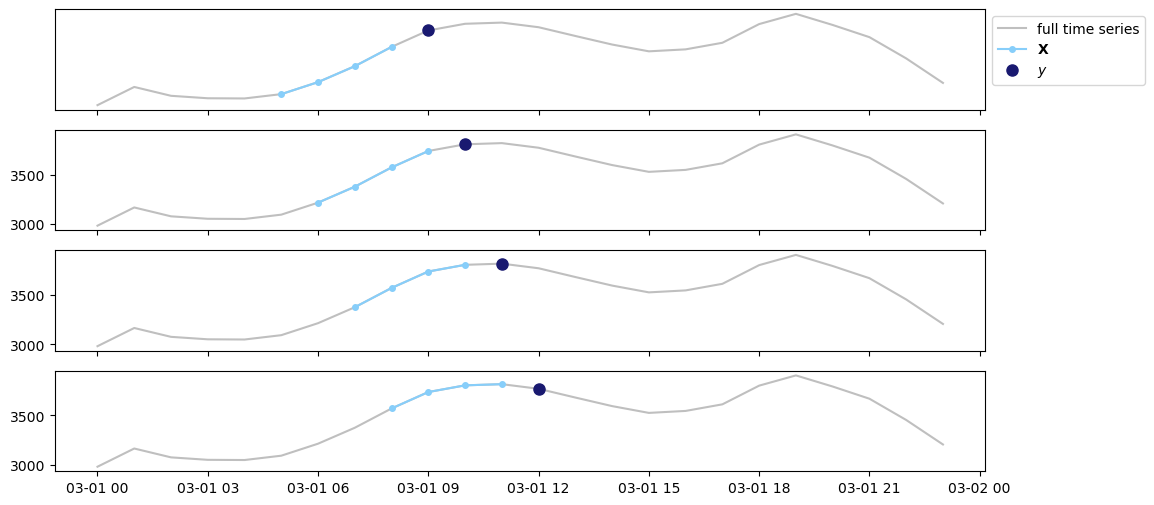

time: 891 ms (started: 2024-04-03 09:08:53 +02:00)


In [82]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2014-03-01 00:00:00')[0][0]
middle = np.where(new_dataframe.index == '2014-03-01 12:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-03-02 00:00:00')[0][0]
#sliding window width:
window = 4
#Plotting a sliding interval sample:
fig, ax = plt.subplots(nrows=4,sharex=True);
for i in range(4): 
    full = new_dataframe.iloc[start:end]['load']
    train = new_dataframe.iloc[middle - i - window:middle - i ]['load']
    predict = new_dataframe.iloc[middle - i:middle - i + 1]['load']

    ax[3-i].plot((full + 2*i),c='grey', alpha=0.5);
    ax[3-i].plot((train + 2*i),c=colors['lightskyblue'], markersize=4,marker='o')
    ax[3-i].plot((predict + 2*i),c=colors['midnightblue'], markersize=8,marker='o', linestyle='')

ax[0].get_yaxis().set_ticks([]);
ax[0].legend(['full time series','$\mathbf{X}$','$y$'],bbox_to_anchor=(1, 1));

Lets follow the same logic and create our feature matrix A in this way.

In [83]:
# Step 2: Preparing the Dataset for Modeling
# -------------------------------------------

# Define the start and end indices for our modeling period.
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-11-04 00:00:00')[0][0]

# Now we set a wider window for extracting features to use in our SVM model.
window = 48  # This should match with your modeling requirement, we're using 48 for illustration.

time: 0 ns (started: 2024-04-03 09:08:54 +02:00)


In [84]:
# Step 3: Initialize lists for features, labels, and column names
dataX, dataY, column_names_list = [], [], []

for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names_list.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names_list)

dataX = pd.DataFrame(dataX, columns=column_names, index=new_dataframe.index[start + window:end])
dataY = pd.Series(dataY, name='true_load', index=new_dataframe.index[start + window:end])

time: 1.7 s (started: 2024-04-03 09:08:54 +02:00)


In [85]:
#Original DF:
new_dataframe.loc['2012-09-01 00:00:00':'2012-09-04 00:00:00'].head(6)

,median,std,T,load
2012-09-01 00:00:00,3750.5,593.535976,59.33,2719.0
2012-09-01 01:00:00,3750.5,588.651369,69.67,2817.0
2012-09-01 02:00:00,3750.5,584.145753,67.33,2664.0
2012-09-01 03:00:00,3750.5,580.500794,69.33,2580.0
2012-09-01 04:00:00,3750.5,577.913412,67.67,2537.0
2012-09-01 05:00:00,3750.5,581.252095,65.00,2525.0


time: 15 ms (started: 2024-04-03 09:08:56 +02:00)


In [86]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2012-09-03 00:00:00,3750.5,593.535976,59.33,2719.0,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,...,64.67,3270.0,3107.5,400.451258,62.0,3070.0,3107.5,400.479656,60.00,2825.0
2012-09-03 01:00:00,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,67.33,2664.0,3750.5,580.500794,...,62.00,3070.0,3107.5,400.479656,60.0,2825.0,3107.5,398.969315,64.67,2630.0


time: 0 ns (started: 2024-04-03 09:08:56 +02:00)


--> Please see that 2012-09-03 00:00:00 2630.0 in dataY is the same value for:
    2012-09-03 01:00:00 load_t_48 in dataX.
    
    Alignment: The last value in each dataX row (load_t_48) represents the 'load' at the end of the 48-hour window. The following value (which becomes the corresponding dataY value) is the 'load' you're trying to predict. That's why the dataY value for 2012-09-03 00:00:00 matches the last 'load' feature (load_t_48) for the dataX row starting at 2012-09-03 01:00:00. It signifies that dataY is correctly set as the target 'load' immediately following each feature window in dataX.

    Correctness: This setup indicates you've correctly shifted your target variable ('load') by one time step ahead of your features in dataX. This is a common approach in time series forecasting, where the goal is to predict future values based on past observations.

    When the window moves forward by one hour (from starting at 2012-09-01 00:00:00 to starting at 2012-09-01 01:00:00), the last value of this new window (load_t_48 for 2012-09-03 01:00:00) becomes the first 'load' value to predict (2012-09-03 00:00:00 in dataY).

In [87]:
dataY.head(2)

2012-09-03 00:00:00    2630.0
2012-09-03 01:00:00    2403.0
Name: true_load, dtype: float64

time: 0 ns (started: 2024-04-03 09:08:56 +02:00)


In [88]:
# # Correlation Matrix
# correlationMatrix = pd.DataFrame(dataX).corr() 

# f = plt.figure(figsize=(12, 6))
# plt.matshow(correlationMatrix, fignum=f.number)
# plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
# plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.show()

time: 16 ms (started: 2024-04-03 09:08:56 +02:00)


In [89]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
count,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,...,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04
mean,4.126890e-16,-4.126890e-16,-1.674680e-16,1.226105e-16,1.943825e-16,4.007270e-16,-3.708220e-16,-3.289550e-17,-1.166295e-16,7.177199e-17,...,1.555060e-16,-2.721355e-16,-5.741759e-16,-7.655679e-16,2.870880e-16,-1.854110e-16,6.339859e-16,-1.256010e-16,-2.392400e-17,-1.764395e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,...,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.311026e+00,-2.568864e+00,-3.149160e+00,-2.364007e+00,-2.310945e+00,-2.568901e+00,-3.149111e+00,-2.363968e+00,-2.310863e+00,-2.568927e+00,...,-3.148892e+00,-2.364704e+00,-2.310965e+00,-2.569386e+00,-3.148870e+00,-2.364718e+00,-2.311106e+00,-2.569493e+00,-3.148836e+00,-2.364747e+00
25%,-6.392120e-01,-6.328903e-01,-7.643083e-01,-7.708135e-01,-6.391302e-01,-6.328301e-01,-7.642519e-01,-7.707941e-01,-6.390483e-01,-6.327681e-01,...,-7.617216e-01,-7.714148e-01,-6.371107e-01,-6.309856e-01,-7.616627e-01,-7.714386e-01,-6.371837e-01,-6.308675e-01,-7.616067e-01,-7.714603e-01
50%,-1.347291e-01,-1.008269e-01,9.308555e-02,1.184520e-01,-1.354634e-01,-1.008014e-01,9.314447e-02,1.184610e-01,-1.361976e-01,-1.007916e-01,...,7.950615e-02,1.196863e-01,-1.357709e-01,-1.023340e-01,7.957783e-02,1.196574e-01,-1.358235e-01,-1.022454e-01,7.964181e-02,1.196396e-01
75%,6.215871e-01,4.280362e-01,7.966014e-01,6.798121e-01,6.212612e-01,4.280328e-01,7.966624e-01,6.798144e-01,6.213435e-01,4.278247e-01,...,8.007057e-01,6.792978e-01,6.219543e-01,4.269190e-01,8.007884e-01,6.792656e-01,6.219327e-01,4.268832e-01,8.008591e-01,6.792504e-01
max,4.123172e+00,4.490247e+00,2.443456e+00,3.418892e+00,4.123255e+00,4.490566e+00,2.443522e+00,3.418862e+00,4.123339e+00,4.490861e+00,...,2.449162e+00,3.418543e+00,4.124801e+00,4.495797e+00,2.449270e+00,3.418495e+00,4.124922e+00,4.495857e+00,2.449356e+00,3.418492e+00


time: 406 ms (started: 2024-04-03 09:08:56 +02:00)


In [90]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2014-10-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Lets use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (744, 192) (744,)
Test data shape:  (72, 192) (72,)
time: 16 ms (started: 2024-04-03 09:08:56 +02:00)


## Model Training and Predictions

As we have seen in the lecture, there are 3 important hyperparameters to decide: C, epsilon and kernel. We also need to feed the tol value as we are solving a convex optimization problem.

In [91]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)
 

time: 0 ns (started: 2024-04-03 09:08:56 +02:00)


In [92]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(X_train, y_train)

SVR(kernel='linear', tol=1e-05)

time: 31 ms (started: 2024-04-03 09:08:56 +02:00)


In [93]:
#Model Predictions:
#------------------
#scoreTraining = model.score(X_train, y_train)
#print('-----------------------------------')
#print('SVM Regression Training R^2 Score: ', scoreTraining)
#print('-----------------------------------')
scoreValidation = model.score(X_test, y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

-----------------------------------
SVM Regression Validation R^2 Score:  0.9235792821874811
-----------------------------------
time: 15 ms (started: 2024-04-03 09:08:57 +02:00)


Training MSE: 8019.511874017614
Test MSE: 15620.405320125794


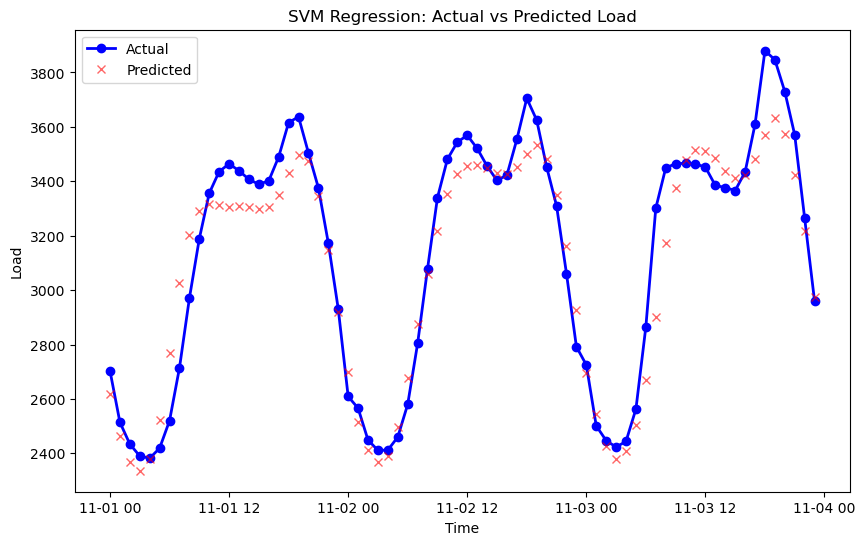

time: 234 ms (started: 2024-04-03 09:08:57 +02:00)


In [94]:
# Predict on training and test sets
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# Evaluate the model
print(f"Training MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred)}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o', linestyle='-', linewidth=2)
plt.plot(y_test.index, y_test_pred, label='Predicted', color='red', alpha=0.6, marker='x', linestyle='None')
plt.title('SVM Regression: Actual vs Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

### Forecasting further in time...

Lets use the SVM to predict further horizons by just using the training wisdom. Here we will follow a similar anology. We need to update the passed information about the past as we progress. Here, it is a bit more difficult as we need to update the created features as well. Lets see how it can be implemented.

In [95]:
#Checking Data:
data.sample(3)

,load,T
2008-04-22 17:00:00,3394.0,72.33
2009-07-26 07:00:00,2553.0,67.33
2013-10-03 04:00:00,2267.0,53.33


time: 16 ms (started: 2024-04-03 09:08:57 +02:00)


In [96]:
# Step 1: Feature Engineering
# ---------------------------
# Extract only the 'load' data for statistical feature generation.
load_data = data[['load']]

# Set the rolling window width to 24 hours for calculating rolling statistics.
width = 24
window = load_data.rolling(window=width)

# Create a new DataFrame that includes rolling statistics and temperature data.
new_dataframe = pd.concat([window.median(), window.std(), data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std', 'T', 'load']
new_dataframe.dropna(inplace=True)
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78865 entries, 2006-01-01 23:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78865 non-null  float64
 1   std     78865 non-null  float64
 2   T       78865 non-null  float64
 3   load    78865 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 63 ms (started: 2024-04-03 09:08:57 +02:00)


In [97]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 23:00:00,3512.0,471.067697,24.33,3255.0


time: 0 ns (started: 2024-04-03 09:08:57 +02:00)


In [98]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-11-04 00:00:00')[0][0]
#setting windows width:
window = 48
#emply datalist

# Step 3: Initialize lists for features, labels, and column names
dataX, dataY, column_names_list = [], [], []

for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names_list.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names_list)

dataX = pd.DataFrame(dataX, columns=column_names, index=new_dataframe.index[start + window:end])
dataY = pd.Series(dataY, name='true_load', index=new_dataframe.index[start + window:end])

time: 1.91 s (started: 2024-04-03 09:08:57 +02:00)


In [99]:
#Original DF:
new_dataframe.loc['2012-09-01 00:00:00':'2012-09-04 00:00:00'].head(6)

,median,std,T,load
2012-09-01 00:00:00,3750.5,593.535976,59.33,2719.0
2012-09-01 01:00:00,3750.5,588.651369,69.67,2817.0
2012-09-01 02:00:00,3750.5,584.145753,67.33,2664.0
2012-09-01 03:00:00,3750.5,580.500794,69.33,2580.0
2012-09-01 04:00:00,3750.5,577.913412,67.67,2537.0
2012-09-01 05:00:00,3750.5,581.252095,65.00,2525.0


time: 16 ms (started: 2024-04-03 09:08:59 +02:00)


In [100]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2012-09-03 00:00:00,3750.5,593.535976,59.33,2719.0,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,...,64.67,3270.0,3107.5,400.451258,62.0,3070.0,3107.5,400.479656,60.00,2825.0
2012-09-03 01:00:00,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,67.33,2664.0,3750.5,580.500794,...,62.00,3070.0,3107.5,400.479656,60.0,2825.0,3107.5,398.969315,64.67,2630.0


time: 15 ms (started: 2024-04-03 09:08:59 +02:00)


In [101]:
dataY.head(2)

2012-09-03 00:00:00    2630.0
2012-09-03 01:00:00    2403.0
Name: true_load, dtype: float64

time: 15 ms (started: 2024-04-03 09:08:59 +02:00)


In [102]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
count,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,...,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04
mean,4.126890e-16,-4.126890e-16,-1.674680e-16,1.226105e-16,1.943825e-16,4.007270e-16,-3.708220e-16,-3.289550e-17,-1.166295e-16,7.177199e-17,...,1.555060e-16,-2.721355e-16,-5.741759e-16,-7.655679e-16,2.870880e-16,-1.854110e-16,6.339859e-16,-1.256010e-16,-2.392400e-17,-1.764395e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,...,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.311026e+00,-2.568864e+00,-3.149160e+00,-2.364007e+00,-2.310945e+00,-2.568901e+00,-3.149111e+00,-2.363968e+00,-2.310863e+00,-2.568927e+00,...,-3.148892e+00,-2.364704e+00,-2.310965e+00,-2.569386e+00,-3.148870e+00,-2.364718e+00,-2.311106e+00,-2.569493e+00,-3.148836e+00,-2.364747e+00
25%,-6.392120e-01,-6.328903e-01,-7.643083e-01,-7.708135e-01,-6.391302e-01,-6.328301e-01,-7.642519e-01,-7.707941e-01,-6.390483e-01,-6.327681e-01,...,-7.617216e-01,-7.714148e-01,-6.371107e-01,-6.309856e-01,-7.616627e-01,-7.714386e-01,-6.371837e-01,-6.308675e-01,-7.616067e-01,-7.714603e-01
50%,-1.347291e-01,-1.008269e-01,9.308555e-02,1.184520e-01,-1.354634e-01,-1.008014e-01,9.314447e-02,1.184610e-01,-1.361976e-01,-1.007916e-01,...,7.950615e-02,1.196863e-01,-1.357709e-01,-1.023340e-01,7.957783e-02,1.196574e-01,-1.358235e-01,-1.022454e-01,7.964181e-02,1.196396e-01
75%,6.215871e-01,4.280362e-01,7.966014e-01,6.798121e-01,6.212612e-01,4.280328e-01,7.966624e-01,6.798144e-01,6.213435e-01,4.278247e-01,...,8.007057e-01,6.792978e-01,6.219543e-01,4.269190e-01,8.007884e-01,6.792656e-01,6.219327e-01,4.268832e-01,8.008591e-01,6.792504e-01
max,4.123172e+00,4.490247e+00,2.443456e+00,3.418892e+00,4.123255e+00,4.490566e+00,2.443522e+00,3.418862e+00,4.123339e+00,4.490861e+00,...,2.449162e+00,3.418543e+00,4.124801e+00,4.495797e+00,2.449270e+00,3.418495e+00,4.124922e+00,4.495857e+00,2.449356e+00,3.418492e+00


time: 391 ms (started: 2024-04-03 09:08:59 +02:00)


In [103]:
#Temperature for weather forecasting (later used in multistep forecasting):
temp_test = dataX['T_t_1']
temp_test

2012-09-03 00:00:00    0.607728
2012-09-03 01:00:00    1.139868
2012-09-03 02:00:00    1.019441
2012-09-03 03:00:00    1.122370
2012-09-03 04:00:00    1.036939
                         ...   
2014-11-03 19:00:00   -0.490004
2014-11-03 20:00:00   -0.506987
2014-11-03 21:00:00   -0.506987
2014-11-03 22:00:00   -0.506987
2014-11-03 23:00:00   -0.490004
Name: T_t_1, Length: 19008, dtype: float64

time: 15 ms (started: 2024-04-03 09:08:59 +02:00)


In [104]:
# Step 4: Splitting the Data for Training and Testing
# ----------------------------------------------------
train_start_dt = '2014-10-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Lets use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (744, 192) (744,)
Test data shape:  (72, 192) (72,)
time: 32 ms (started: 2024-04-03 09:08:59 +02:00)


In [105]:
# Initialize a list to store the last 'load' values used for updating the features.
s_window = 24  # This represents the sliding window size for capturing recent load history.
last_loads = list()

# Extract the first set of features from the test data to initialize the forecasting process.
X_last = X_test.iloc[0:1]

X_last.tail()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2014-11-01,-0.129831,0.115119,-0.335611,-1.054167,-0.129749,0.109072,0.024697,-1.428379,-0.129667,0.107447,...,-0.246579,0.016319,-0.651808,-0.985907,-0.229512,-0.292029,-0.651882,-0.963692,-0.332482,-0.734034


time: 15 ms (started: 2024-04-03 09:08:59 +02:00)


In [106]:
# Populate the 'last_loads' list with the most recent 'load' values from 'X_last'.
# These values will be updated as new predictions are made and used to update future feature sets.
for i in range(1, s_window + 1):
    column = 'load_t_' + str(i)
    last_loads.append(X_last[column][0])
last_loads = np.array(last_loads)
last_loads

array([-1.05416662, -1.42837947, -1.5815736 , -1.65635407, -1.63669901,
       -1.46024993, -0.97911984, -0.06322531,  0.38045911,  0.3893592 ,
        0.40895085,  0.32341297,  0.25213262,  0.1594695 ,  0.15768899,
        0.10067245,  0.08108038,  0.17552834,  0.44815689,  0.75818488,
        0.6637238 ,  0.46593522,  0.02047563, -0.57643783])

time: 0 ns (started: 2024-04-03 09:08:59 +02:00)


In [107]:
# Step 2: Predicting Future Loads
# ----------------------------------
# Initialize a Series to store predictions.
y_predicted = pd.Series(index=y_test.index)

time: 0 ns (started: 2024-04-03 09:08:59 +02:00)


In [108]:
#import lib
from pandas.tseries.offsets import DateOffset

time: 0 ns (started: 2024-04-03 09:08:59 +02:00)


In [109]:
# Convert the initial test features to numpy array for processing.
X_test_last = X_last.to_numpy()
X_test_last.shape

(1, 192)

time: 0 ns (started: 2024-04-03 09:08:59 +02:00)


In [110]:
X_test_last

array([[-1.29831251e-01,  1.15119221e-01, -3.35611380e-01,
        -1.05416662e+00, -1.29749182e-01,  1.09071635e-01,
         2.46968596e-02, -1.42837947e+00, -1.29667114e-01,
         1.07446998e-01, -6.11655152e-02, -1.58157360e+00,
        -1.29585046e-01,  1.02084079e-01, -1.64022169e-01,
        -1.65635407e+00, -1.29502980e-01,  9.40726648e-02,
        -2.32393598e-01, -1.63669901e+00, -1.29420914e-01,
         8.46275089e-02, -2.83785718e-01, -1.46024993e+00,
        -1.29338849e-01,  7.56909748e-02, -3.52168961e-01,
        -9.79119835e-01, -1.29256785e-01,  7.81966328e-02,
        -3.69599832e-01, -6.32253087e-02, -9.32567418e-02,
         8.91679337e-02, -4.37989350e-01,  3.80459106e-01,
        -9.31746653e-02,  9.17253913e-02, -4.20936176e-01,
         3.89359202e-01, -9.31063467e-02,  8.96481911e-02,
        -2.48943916e-01,  4.08950853e-01, -1.27356740e-01,
         6.19661433e-02, -9.44422956e-02,  3.23412970e-01,
        -1.81214266e-01,  3.36424089e-02,  1.11549330e-0

time: 0 ns (started: 2024-04-03 09:08:59 +02:00)


In [111]:
# Iterate over the test data indices to make predictions and update the features accordingly.
n_features = 4  # Number of features used in prediction (median, std, temp, load)
dummy_array = np.zeros((1, X_test_last.shape[1]))  # Helper array for feature scaling

time: 0 ns (started: 2024-04-03 09:08:59 +02:00)


In [112]:
# Debugging: Print the start and end of the temp_test to verify the range
print(f"Start of temp_test: {temp_test.index.min()}")
print(f"End of temp_test: {temp_test.index.max()}")

# Iterate over the test data indices to make predictions and update the features accordingly
case_indices = y_test.index
for case_index in case_indices:
    # print(f"Processing case_index: {case_index}")  # Debugging: current index being processed
    
    # Predict the load using the SVM model and update 'y_predicted' Series
    load_prediction = svr.predict(X_test_last).flatten()[0]
    y_predicted.update(pd.Series(load_prediction, index=[case_index]))
    
    # Scale the predicted 'load' for feature update
    dummy_array = np.zeros((1, X_test_last.shape[1]))
    dummy_array[0, -1] = load_prediction  # Assuming the last column in X_test_last is 'load'
    load_scaled = sX.transform(dummy_array)[0, -1]
    
    # Update the 'last_loads' list with the new prediction
    last_loads = np.roll(last_loads, -1)
    last_loads[-1] = load_scaled
    
    # Compute new statistical features based on updated 'last_loads'
    median_i = np.median(last_loads)
    std_i = np.std(last_loads)
    
    # Handle temperature feature update with checks for missing timestamps
    time_index = pd.Timestamp(case_index) + DateOffset(hours=1)
    print(f"Looking for temperature at: {time_index}")  # Debugging: intended temperature timestamp
    
    if time_index in temp_test.index:
        temp_i = temp_test.loc[time_index]
    else:
        print(f"Timestamp {time_index} not found in temp_test. Using the last known temperature.")
        temp_i = temp_test.iloc[-1]  # Fallback if timestamp not found
    
    # Update features in 'X_test_last' for the next prediction
    X_test_last = np.roll(X_test_last, -4)  # Assuming 4 features: median, std, T, load
    X_test_last[0, -4:] = [median_i, std_i, temp_i, load_scaled]

# At the end of this loop, 'y_predicted' will contain all the load predictions

Start of temp_test: 2012-09-03 00:00:00
End of temp_test: 2014-11-03 23:00:00
Looking for temperature at: 2014-11-01 01:00:00
Looking for temperature at: 2014-11-01 02:00:00
Looking for temperature at: 2014-11-01 03:00:00
Looking for temperature at: 2014-11-01 04:00:00
Looking for temperature at: 2014-11-01 05:00:00
Looking for temperature at: 2014-11-01 06:00:00
Looking for temperature at: 2014-11-01 07:00:00
Looking for temperature at: 2014-11-01 08:00:00
Looking for temperature at: 2014-11-01 09:00:00
Looking for temperature at: 2014-11-01 10:00:00
Looking for temperature at: 2014-11-01 11:00:00
Looking for temperature at: 2014-11-01 12:00:00
Looking for temperature at: 2014-11-01 13:00:00
Looking for temperature at: 2014-11-01 14:00:00
Looking for temperature at: 2014-11-01 15:00:00
Looking for temperature at: 2014-11-01 16:00:00
Looking for temperature at: 2014-11-01 17:00:00
Looking for temperature at: 2014-11-01 18:00:00
Looking for temperature at: 2014-11-01 19:00:00
Looking fo

c:\Users\JuanFernandez\anaconda3\envs\exergy_time_series_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\exergy_time_series_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\exergy_time_series_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\exergy_time_series_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\exergy_time_series_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR 

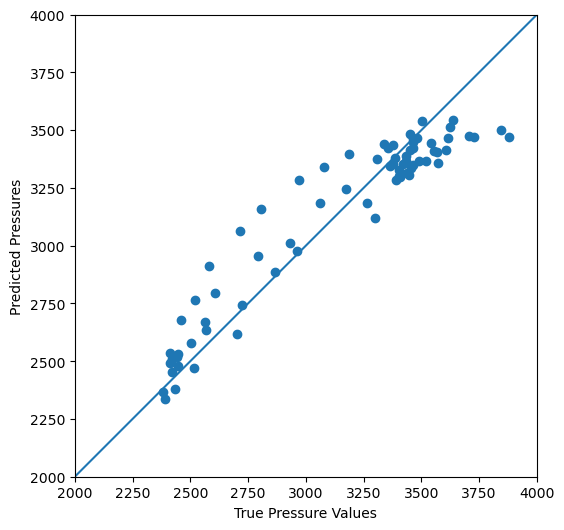

time: 157 ms (started: 2024-04-03 09:09:00 +02:00)


In [113]:
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_predicted)
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

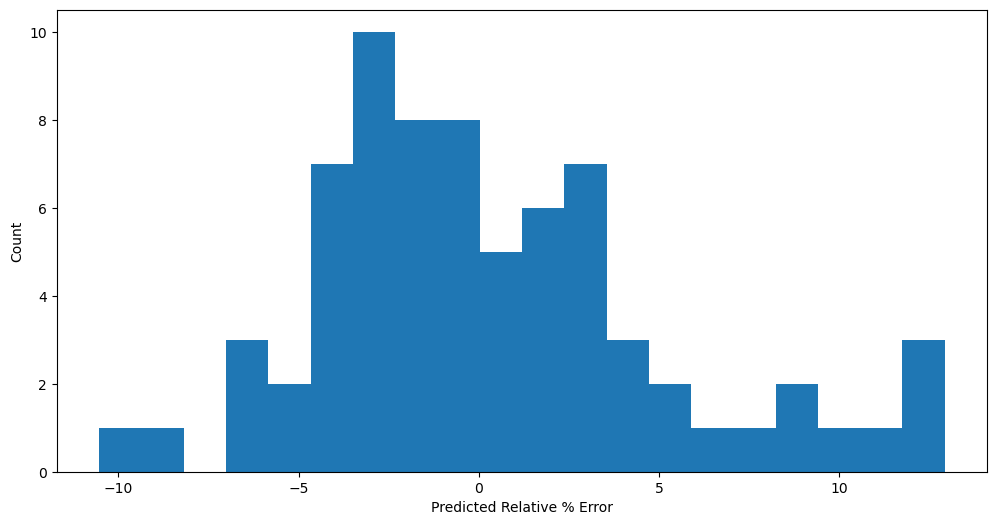

time: 141 ms (started: 2024-04-03 09:09:00 +02:00)


In [114]:
# Calculating the error variations:
error_nn = (y_predicted - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [115]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(y_predicted - y_test)/y_test*100
np.average(error_nn)

0.30034047586917684

time: 0 ns (started: 2024-04-03 09:09:00 +02:00)


In [116]:
#Calculating R2 value:
r2_test = r2_score(y_test, y_predicted)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.89
time: 0 ns (started: 2024-04-03 09:09:00 +02:00)


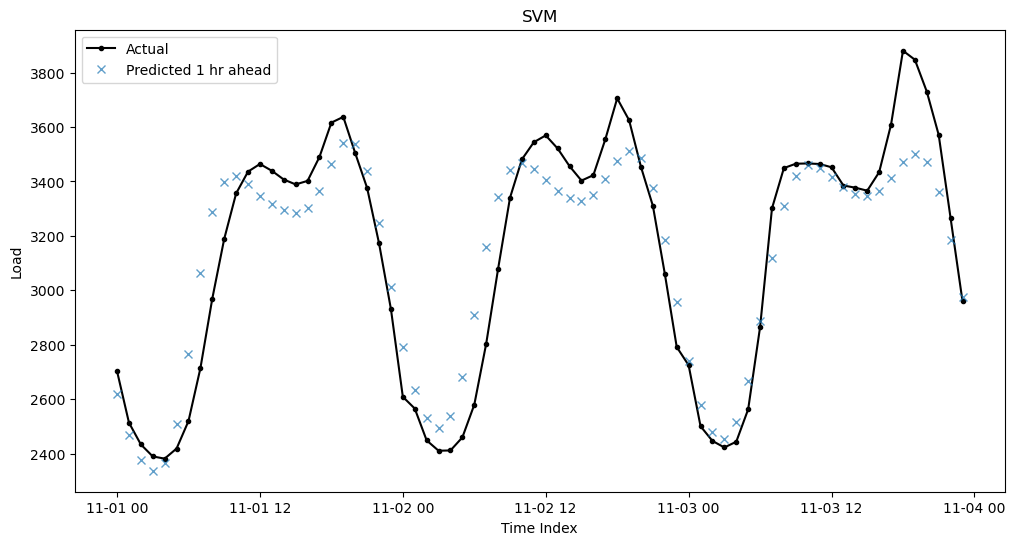

time: 265 ms (started: 2024-04-03 09:09:00 +02:00)


In [117]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test, 'k.-');
plt.plot(y_predicted, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

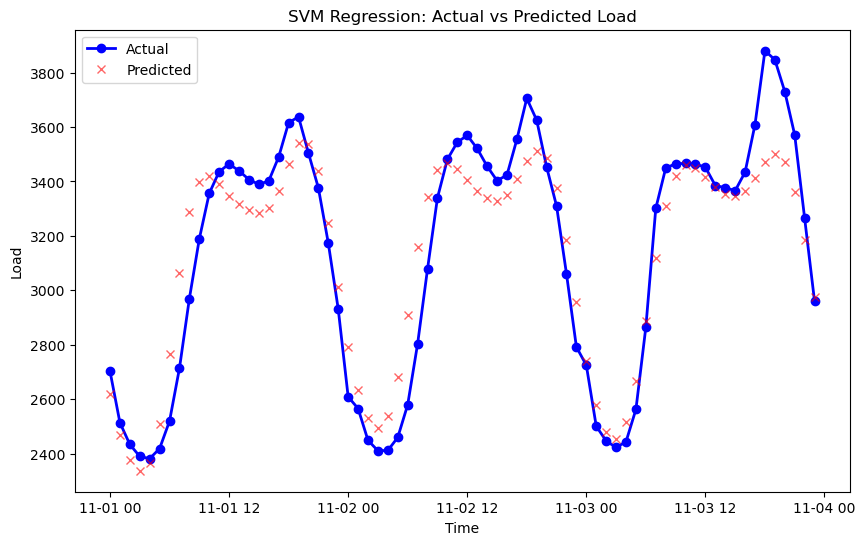

time: 203 ms (started: 2024-04-03 09:09:00 +02:00)


In [118]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o', linestyle='-', linewidth=2)
plt.plot(y_predicted.index, y_predicted, label='Predicted 1 hr ahead', color='red', alpha=0.6, marker='x', linestyle='None')
plt.title('SVM Regression: Actual vs Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

# Self Study

It would be a good exercise to combine SVM with PCA. 

i) Create a feature matrix X with a much larger sliding window. You may also add additional features.

ii) Transform and reduce the dimensionality via PCA (#_components should be high enough to cover >95% variance).

iii) Feed transformed X into SVM. 

iV) Try to predict much further points in time.



# Reading Material

https://en.wikipedia.org/wiki/Time_series

https://earthobservatory.nasa.gov/features/WxForecasting

https://robjhyndman.com/hyndsight/forecasting-competitions/

https://en.wikipedia.org/wiki/Autocorrelation

https://en.wikipedia.org/wiki/Partial_autocorrelation_function

Dataset source: Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, 2016.

https://www.ge.com/power/future-of-energy

https://www.ge.com/news/reports/part-1-transformation-change-energy-ecosystem